## Correlations between CEC Centrality Measures with Uniform and Structured PageRank Centralities

### Considering Random Graphs Constructed from E-R Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from halp.undirected_hypergraph import UndirectedHypergraph
from halp.utilities import undirected_graph_transformations, undirected_matrices
import scipy

In [125]:
# PageRank functions

def power_iteration(A, num_simulations: int):

    # Code taken from "https://en.wikipedia.org/wiki/Power_iteration"
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1, 1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

def hg_pagerank_power(T, alpha, num_sims):
    nodes = list(range(len(T)))
    n = len(nodes)

    T = alpha*T + (1-alpha)/n*np.ones((n,n)) # PageRank w/ teleportation
    
    res_pgrk = power_iteration(T.T, 100) # power method
    
    return res_pgrk


def hg_pagerank_full_eig_decomp(T, alpha):
    """
    
    Computes the pagerank for a Hypergraph H, for a random walk determined by transition matrix T.
    Computes by finding the left eigenvector associated to the eigenvalue \lambda = 1
    Does so by finding all eigenpairs of the matrix and then filtered
    (Takes long time for large matrices, see hg_pagerank_fast instead)
    
    """
    
    
    # p(t+1)_i = a * p(t)_i*T + (1-a)/n * 1
    
    nodes = list(range(len(T)))
    n = len(nodes)
    
    T = alpha*T + (1-alpha)/n*np.ones((n,n))
    
    # Find the right eigenvalue associated with the 1 eigenvalue (note the transpose of T)
    values, vectors = np.linalg.eig(T.T)
    print(values.max())
    vector = vectors[:,np.isclose(values, values.max())] # find correct evector, code used from: 
    vector = vector[:,0]
    
    # normalise the stationary distribution
    stat_dist = vector / vector.sum()
    stat_dist = stat_dist.real
    
    
    #return the hypergraph PageRank
    return stat_dist

In [115]:
# generate random E-R graph

def generate_er_graph(N, p):
    G = nx.bipartite.random_graph(N, np.round(np.sqrt(N),0).astype(int), 0.4)
    I = nx.bipartite.biadjacency_matrix(G, row_order = range(N)).toarray()
    return I

In [138]:
# calculate the CEC centrality


# using SVD approach
def compute_cec_ranking_svd(A):
    # using low rank approximation
    rank = 1

    # Perform SVD on im and obtain individual matrices
    P, D, Q = np.linalg.svd(A, full_matrices=True)
    
    return P[:, :rank]

# using power method approach
def compute_cec_ranking_power(A, num_sims):
    # implementing the power method
    # code altered from: https://en.wikipedia.org/wiki/Power_iteration
    b_k = np.random.rand(len(A))

    for _ in range(num_sims):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

In [130]:
# compute correlation between CEC and PageRank

def ER_correlation_cec_pgrnk(N, gamma):
    """
    
    Computes the correlation between the CEC centrality measure and the PageRank of a non-linear walker
    for a random hypergraph generated via the E-R model.
    
    
    """
    
    # generate incidence matrix of hypergraph of N nodes, sqrt(N) hyperedges via E-R model
    
    I = generate_er_graph(N, 0.4)
    # hyper-adjacency matrix
    A = I @ I.T
    # hyper-edges matrix
    C = I.T @ I
    
    
    # find the CEC centrality of the nodes
    res_cec = np.abs(compute_cec_ranking_svd(A))
    res_cec = res_cec.T[0]
    
    # generate transition matrix for PageRank
    
    C_hat = np.diag(np.diag(C))

    K = np.zeros((len(A), len(A)))
    C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))
    C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

    K = (I @ C_alt @ I.T).astype(float)
    K = K - np.diag(np.diag(K)) # simple walk => remove diagonal entries


    T = np.zeros((len(A), len(A)))
    for i in range(len(A)):
        norm = np.sum(K[i])
        if norm ==0:
            pass
        else:
            T[i, :] = K[i] / norm
            
    # find the PageRank centrality for non-linear walker with parameter gamma
    res_pgrk = hg_pagerank_power(T, 0.85, 100)

    return np.corrcoef(res_cec, res_pgrk)[0,1] # return correlation between the two measures

    

In [131]:
ER_correlation_cec_pgrnk(50, -2)

0.9781588903694499

### ER Model: CEC vs Uniform Walker

In [139]:
small_num_list = np.logspace(1.5, 3, 22) # seperate list for large and small graphs
large_num_list = np.logspace(3.1, 4, 8) # average over more realisations of smaller graphs as faster and results more volatile


corr_hist_small = {}
for i in range(30):
    corr_hist_small[i] = []
    for N in small_num_list.astype(int):
        corr_hist_small[i].append(ER_correlation_cec_pgrnk(N, -1)) # gamma = -1 => uniform walker
        
corr_hist = {}
for i in range(3):
    corr_hist[i] = []
    for N in large_num_list.astype(int):
        corr_hist[i].append(ER_correlation_cec_pgrnk(N, -1))


In [140]:
avg_small = np.mean(list(corr_hist_small.values()), axis = 0)
avg_large = np.mean(list(corr_hist.values()), axis = 0)

avg_corr = np.concatenate((avg_small, avg_large))

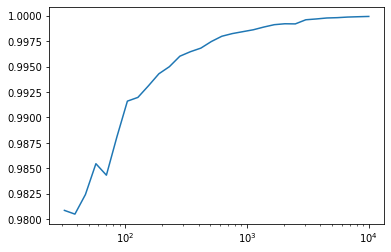

In [141]:
plt.semilogx(np.logspace(1.5, 4, 30),avg_corr)

In [144]:
# saving results

# import pickle

# with open('data/corr_cec_uniform_ER_model.pkl', 'wb') as f: 
#     pickle.dump(avg_corr, f)

### ER Model: CEC vs Structured Walker

In [152]:
small_num_list = np.logspace(1.5, 3, 22) # seperate list for large and small graphs
large_num_list = np.logspace(3.1, 4, 8) # average over more realisations of smaller graphs as faster and results more volatile


corr_hist_small = {}
for i in range(100):
    corr_hist_small[i] = []
    for N in small_num_list.astype(int):
        corr_hist_small[i].append(ER_correlation_cec_pgrnk(N, 1)) # gamma  = 1 => structured walker
        
corr_hist = {}
for i in range(3):
    corr_hist[i] = []
    for N in large_num_list.astype(int):
        corr_hist[i].append(ER_correlation_cec_pgrnk(N, 1))

In [153]:
avg_small = np.mean(list(corr_hist_small.values()), axis = 0)
avg_large = np.mean(list(corr_hist.values()), axis = 0)

avg_corr = np.concatenate((avg_small, avg_large))

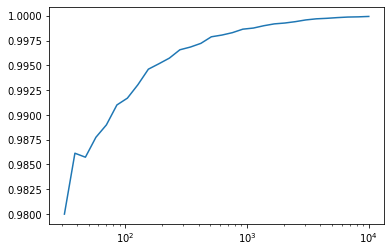

In [154]:
plt.semilogx(np.logspace(1.5, 4, 30),avg_corr)

In [151]:
# saving results

# import pickle

# with open('data/corr_cec_structured_ER_model.pkl', 'wb') as f: 
#     pickle.dump(avg_corr, f)